In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
URLs.PETS

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet'

In [4]:
path = untar_data(URLs.PETS)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/models'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/image_gen'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/small-96'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/crappy'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/small-256')]

In [5]:
path_annotations = path/'annotations'
path_images = path/'images'

In [6]:
filenames = get_image_files(path_images)
filenames[:15]

[PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Maine_Coon_100.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Bengal_82.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_180.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/german_shorthaired_7.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/english_setter_110.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/english_setter_60.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/scottish_terrier_155.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Ragdoll_114.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/pug_144.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Siamese_116.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_27.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxfor

regex ให้ดูจากท้ายสุด .jpg, ตัวเลข เล้วเอาตัวอักษรทั้งหมด ก่อนถึง / มาเป็น label

In [7]:
batchsize = 64
np.random.seed(4200)
regex_pattern = r'/([^/]+)_\d+.jpg$'


default valid percent = 20

from_name_re(path:PathOrStr, fnames:FilePathList, pat:str, valid_pct:float=0.2, **kwargs)

In [8]:
data = ImageDataBunch.from_name_re(path_images, filenames, 
                                   regex_pattern, ds_tfms=get_transforms(), 
                                   size=224, bs=batchsize).normalize()

In [9]:
len(data.train_ds), len(data.valid_ds)

(5912, 1478)

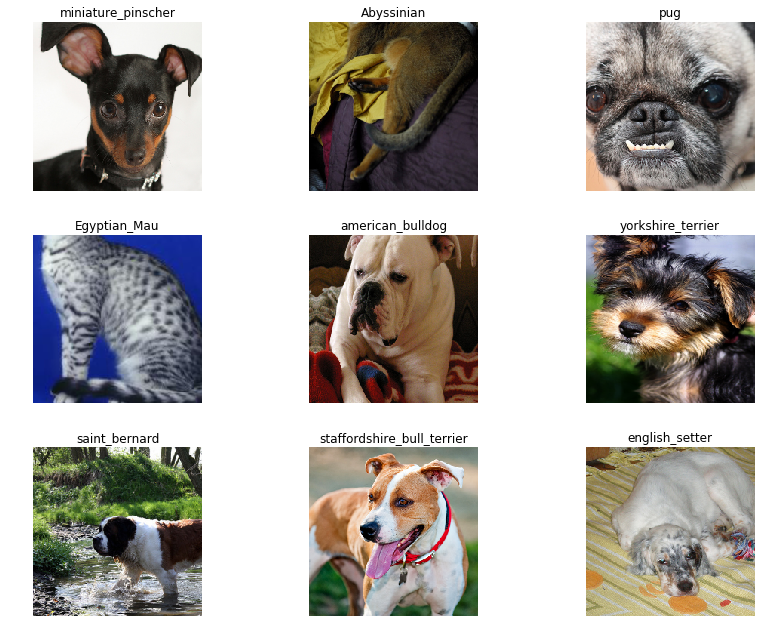

In [10]:
data.show_batch(rows=3, figsize=(12, 9))

In [11]:
print(data.classes)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [12]:
print(data.c)

37


In [13]:
len(data.classes)

37

In [14]:
learner = cnn_learner(data, models.resnet34, metrics=error_rate)

ลอง fit ด้วย ค่า default

In [15]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.396160,0.315080,0.096076,00:24
1,0.559293,0.230185,0.079838,00:24
2,0.344265,0.213118,0.075778,00:24
3,0.255232,0.205589,0.076455,00:23


In [16]:
learner.save('stage-1')

ดูผลลัพธ์

In [17]:
interp = ClassificationInterpretation.from_learner(learner)

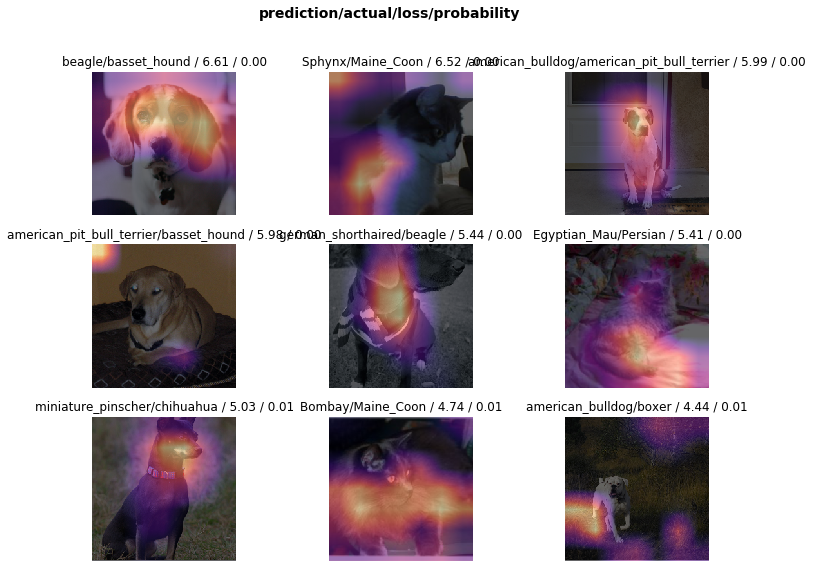

In [18]:
interp.plot_top_losses(9, figsize=(12,9))

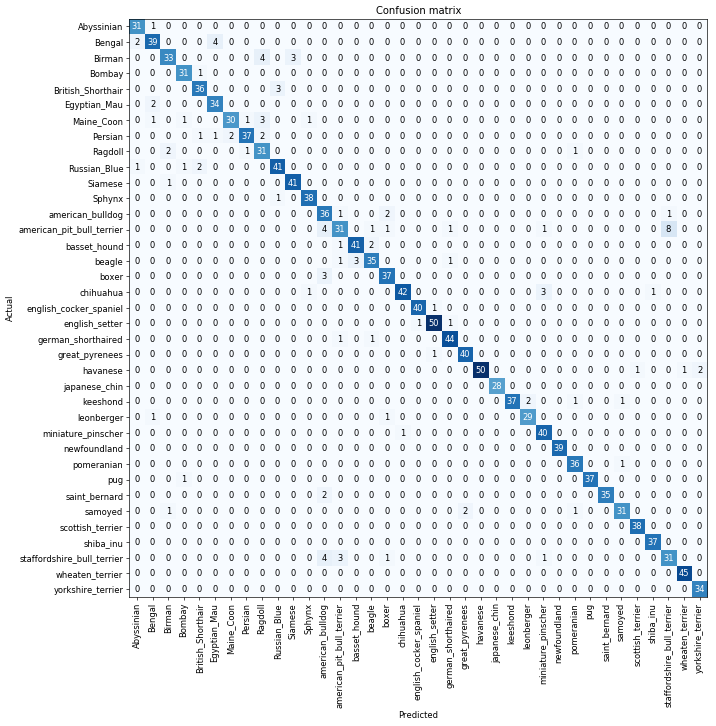

In [19]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [20]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 8),
 ('Bengal', 'Egyptian_Mau', 4),
 ('Birman', 'Ragdoll', 4),
 ('american_pit_bull_terrier', 'american_bulldog', 4),
 ('staffordshire_bull_terrier', 'american_bulldog', 4),
 ('Birman', 'Siamese', 3),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('Maine_Coon', 'Ragdoll', 3),
 ('beagle', 'basset_hound', 3),
 ('boxer', 'american_bulldog', 3),
 ('chihuahua', 'miniature_pinscher', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3),
 ('Bengal', 'Abyssinian', 2),
 ('Egyptian_Mau', 'Bengal', 2),
 ('Persian', 'Maine_Coon', 2),
 ('Persian', 'Ragdoll', 2),
 ('Ragdoll', 'Birman', 2),
 ('Russian_Blue', 'British_Shorthair', 2),
 ('american_bulldog', 'boxer', 2),
 ('basset_hound', 'beagle', 2),
 ('havanese', 'yorkshire_terrier', 2),
 ('keeshond', 'leonberger', 2),
 ('saint_bernard', 'american_bulldog', 2),
 ('samoyed', 'great_pyrenees', 2)]

ดูสถิติของโมเดล

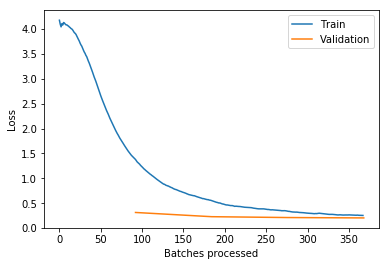

In [21]:
learner.recorder.plot_losses()

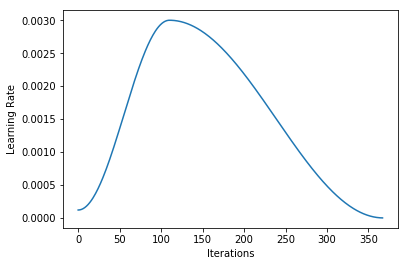

In [22]:
learner.recorder.plot_lr()

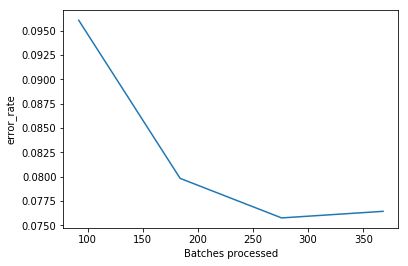

In [23]:
learner.recorder.plot_metrics()

In [24]:
# learn.load('stage-1')

In [25]:
learner.unfreeze()

In [26]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


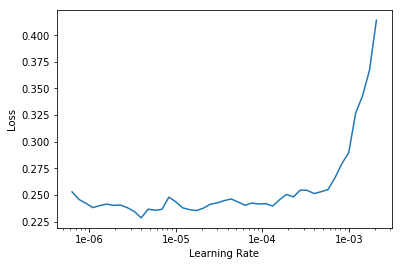

In [27]:
learner.recorder.plot()

In [28]:
learner.fit_one_cycle(3, max_lr=slice(1e-6, 5e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.229811,0.196206,0.069689,00:24
1,0.218452,0.192884,0.068336,00:24
2,0.202047,0.193405,0.064953,00:25


In [29]:
learner.save('stage-2')

ดูผลลัพธ์

In [30]:
interp = ClassificationInterpretation.from_learner(learner)

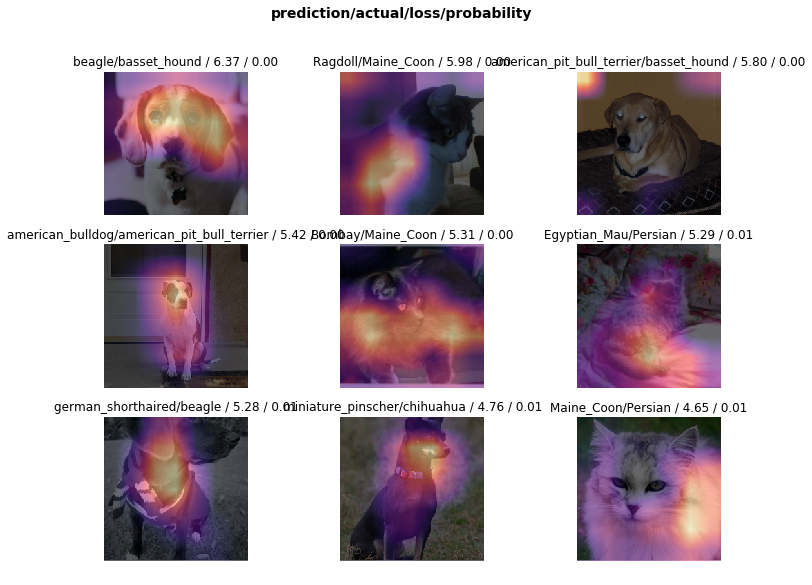

In [31]:
interp.plot_top_losses(9, figsize=(12,9))

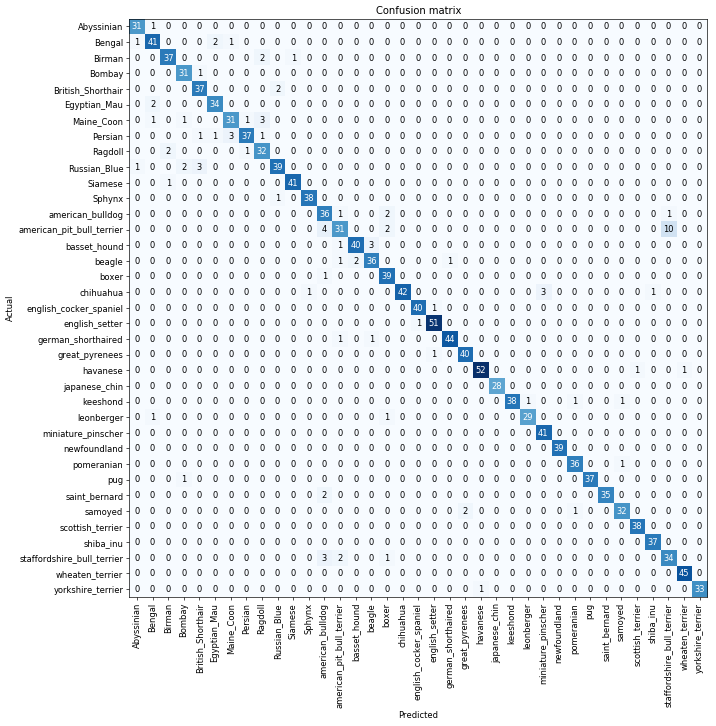

In [32]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [33]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 10),
 ('american_pit_bull_terrier', 'american_bulldog', 4),
 ('Maine_Coon', 'Ragdoll', 3),
 ('Persian', 'Maine_Coon', 3),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('basset_hound', 'beagle', 3),
 ('chihuahua', 'miniature_pinscher', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('Bengal', 'Egyptian_Mau', 2),
 ('Birman', 'Ragdoll', 2),
 ('British_Shorthair', 'Russian_Blue', 2),
 ('Egyptian_Mau', 'Bengal', 2),
 ('Ragdoll', 'Birman', 2),
 ('Russian_Blue', 'Bombay', 2),
 ('american_bulldog', 'boxer', 2),
 ('american_pit_bull_terrier', 'boxer', 2),
 ('beagle', 'basset_hound', 2),
 ('saint_bernard', 'american_bulldog', 2),
 ('samoyed', 'great_pyrenees', 2),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 2)]

ดูสถิติของโมเดล

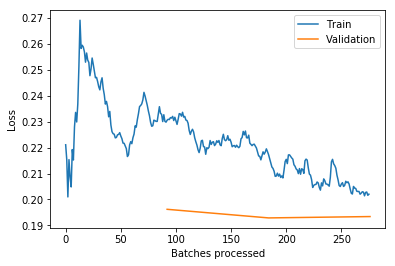

In [34]:
learner.recorder.plot_losses()

กก

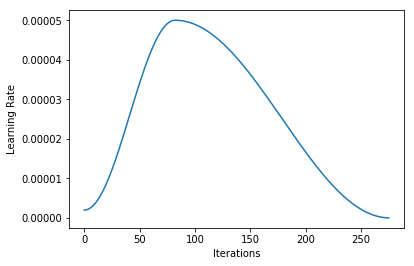

In [35]:
learner.recorder.plot_lr()

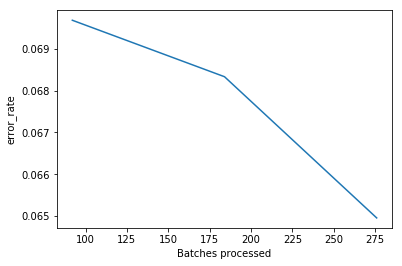

In [36]:
learner.recorder.plot_metrics()

In [37]:
# learn.load('stage-2')